In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt 

# Load data
data_dir = r"C:\Users\Lenovo\Documents\Kuliah - UAJY\Semester V - 2024-2025\Pembelajaran mesin dan Pembelajaran Mendalam - A\Projek UAS\data_paprika" 

# Load dataset with randomization and resizing
data = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    seed=123, 
    image_size=(180, 180), 
    batch_size=16
)

# Print class names
class_names = data.class_names
print("Classes:", class_names)

Found 330 files belonging to 3 classes.
Classes: ['hijau', 'kuning', 'merah']


In [2]:
img_size = 180
batch = 32
validation_split = 0.1

# Load dataset with specified parameters
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch
)

Found 330 files belonging to 3 classes.


In [3]:
total_count = len(dataset)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_count = int(total_count * train_ratio)
val_count = int(total_count * val_ratio)
test_count = total_count - train_count - val_count

print("Total Images:", total_count)
print("Train Images:", train_count)
print("Validation Images:", val_count)
print("Test Images:", test_count)

# Split dataset
train_ds = dataset.take(train_count)
temp_ds = dataset.skip(train_count)
val_ds = temp_ds.take(val_count)
test_ds = temp_ds.skip(val_count)

Total Images: 11
Train Images: 8
Validation Images: 1
Test Images: 2


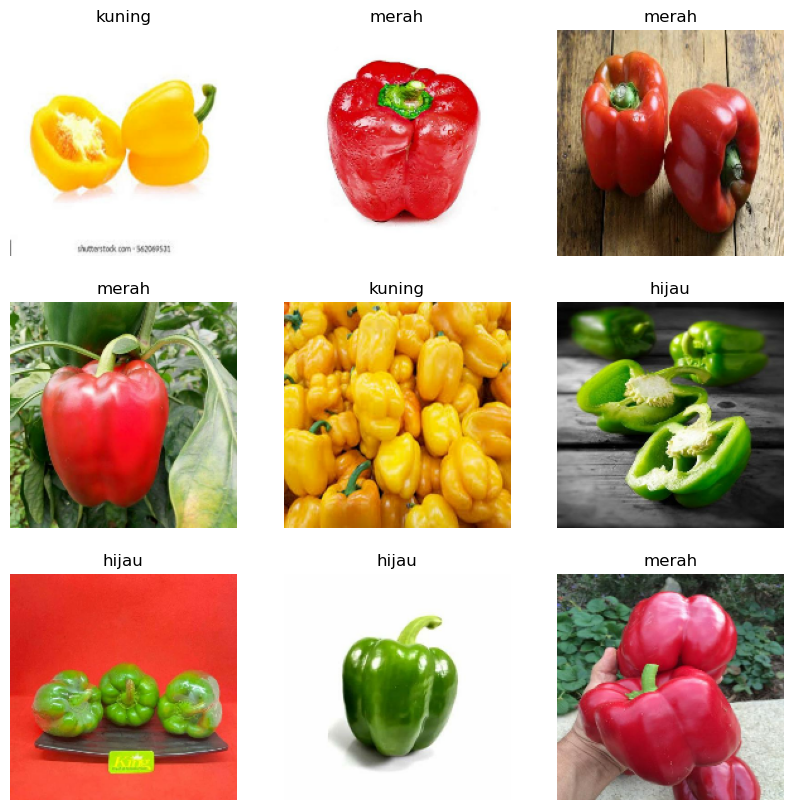

In [4]:
plt.figure(figsize=(10, 10))

# Display training images
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
plt.show()

In [5]:
for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print("Image Array Shape:", images_array.shape)

Image Array Shape: (32, 180, 180, 3)


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


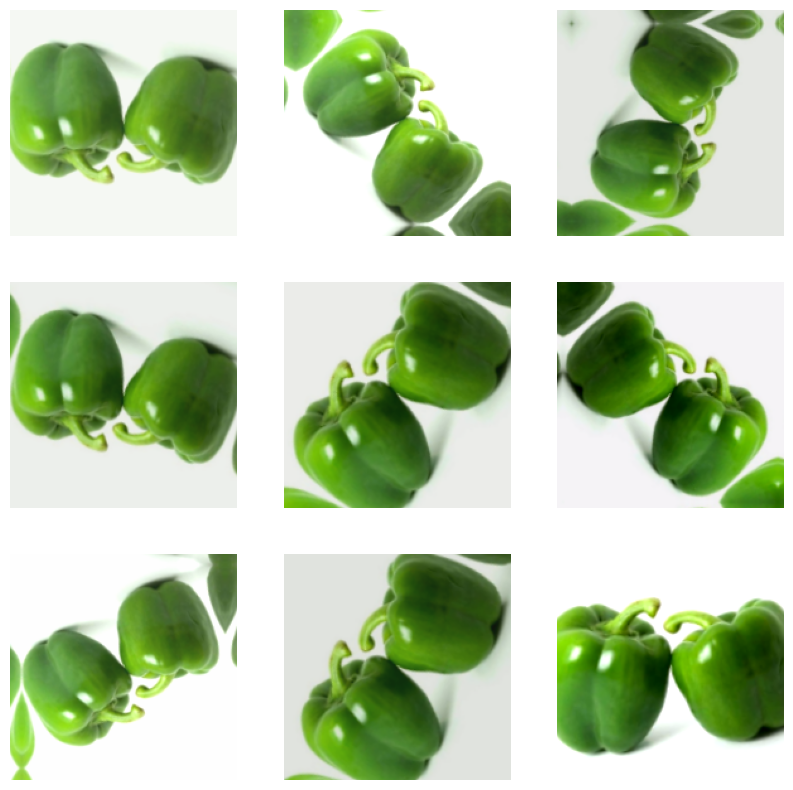

In [6]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Tuner = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=Tuner)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=Tuner)

# Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_size, img_size, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.15),
    layers.RandomBrightness(0.1), 
    layers.RandomContrast(0.25),    
    layers.GaussianNoise(0.1)   
])

plt.figure(figsize=(10, 10))
# Visualize augmented images
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')
plt.show()

In [7]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D
from tensorflow.keras.layers import Flatten, MaxPool2D, AvgPool2D
from tensorflow.keras.layers import Concatenate, Dropout

def googlenet(input_shape, n_classes):
    def inception_block(x, f):
        t1 = Conv2D(f[0], 1, activation='relu')(x)

        t2 = Conv2D(f[1], 1, activation='relu')(x)
        t2 = Conv2D(f[2], 3, padding='same', activation='relu')(t2)
 
        t3 = Conv2D(f[3], 1, activation='relu')(x)
        t3 = Conv2D(f[4], 5, padding='same', activation='relu')(t3)

        t4 = MaxPool2D(3, 1, padding='same')(x)
        t4 = Conv2D(f[5], 1, activation='relu')(t4)

        output = Concatenate()([t1, t2, t3, t4])
        return output
  
    input = Input(input_shape)
    
    x = Conv2D(64, 7, strides=2, padding='same', activation='relu')(input)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    x = Conv2D(64, 1, activation='relu')(x)
    x = Conv2D(192, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(3, strides=2)(x)
    
    x = inception_block(x, [64, 96, 128, 16, 32, 32])
    x = inception_block(x, [128, 128, 192, 32, 96, 64])
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    x = inception_block(x, [192, 96, 208, 16, 48, 64])
    x = inception_block(x, [160, 112, 224, 24, 64, 64])
    x = inception_block(x, [128, 128, 256, 24, 64, 64])
    x = inception_block(x, [112, 144, 288, 32, 64, 64])
    x = inception_block(x, [256, 160, 320, 32, 128, 128])
    x = MaxPool2D(3, strides=2, padding='same')(x)

    x = inception_block(x, [256, 160, 320, 32, 128, 128])
    x = inception_block(x, [384, 192, 384, 48, 128, 128])
    
    x = AvgPool2D(3, strides=1)(x)
    x = Dropout(0.4)(x)
  
    x = Flatten()(x)
    output = Dense(n_classes, activation='softmax')(x)
    
    model = Model(input, output)
    return model

# Input shape and class configuration
input_shape = (180, 180, 3)   
n_classes = 3            

# Clear Keras session
K.clear_session()

# Create model
model = googlenet(input_shape, n_classes)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │       0 │ -                    │
│ (InputLayer)        │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d (Conv2D)     │ (None, 90, 90,    │   9,472 │ input_layer[0][0]    │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d       │ (None, 45, 45,    │       0 │ conv2d[0][0]         │
│ (MaxPooling2D)      │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 45, 45,    │   4,160 │ max_pooling2d[0][0]  │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 45, 45,    │ 110,784 │ conv2d_1[0][0]       │
│                     │ 192)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_1     │ (None, 22, 22,    │       0 │ conv2d_2[0][0]       │
│ (MaxPooling2D)      │ 192)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 22, 22,    │  18,528 │ max_pooling2d_1[0][… │
│                     │ 96)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 22, 22,    │   3,088 │ max_pooling2d_1[0][… │
│                     │ 16)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ max_pooling2d_2     │ (None, 22, 22,    │       0 │ max_pooling2d_1[0][… │
│ (MaxPooling2D)      │ 192)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 22, 22,    │  12,352 │ max_pooling2d_1[0][… │
│                     │ 64)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 22, 22,    │ 110,720 │ conv2d_4[0][0]       │
│                     │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 22, 22,    │  12,832 │ conv2d_6[0][0]       │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 22, 22,    │   6,176 │ max_pooling2d_2[0][… │
│                     │ 32)               │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate         │ (None, 22, 22,    │       0 │ conv2d_3[0][0],      │
│ (Concatenate)       │ 256)              │         │ conv2d_5[0][0],      │
│                     │                   │         │ conv2d_7[0][0],      │
│                     │                   │         │ conv2d_8[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 22, 22,    │  32,896 │ concatenate[0][0]    │
│                     │ 128)              │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 22, 22,    │   8,224 │ concatenate[0][0]    │
│                     │ 32)               │         │                    

 Total params: 6,022,707 (22.97 MB)

 Trainable params: 6,022,707 (22.97 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    mode='max',
    restore_best_weights=True
)

# Train model
history = model.fit(
    train_ds, 
    epochs=30, 
    validation_data=val_ds, 
    callbacks=[early_stopping]
)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4250 - loss: 5.8913 - val_accuracy: 0.3125 - val_loss: 1.1134
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 930ms/step - accuracy: 0.3743 - loss: 1.1250 - val_accuracy: 0.3750 - val_loss: 1.0332
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 909ms/step - accuracy: 0.4043 - loss: 1.0434 - val_accuracy: 0.6875 - val_loss: 0.5939
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 904ms/step - accuracy: 0.6535 - loss: 0.7823 - val_accuracy: 0.6875 - val_loss: 0.5692
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 907ms/step - accuracy: 0.6810 - loss: 0.6195 - val_accuracy: 0.6875 - val_loss: 0.5491
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 932ms/step - accuracy: 0.6705 - loss: 0.5391 - val_accuracy: 0.9688 - val_loss: 0.2079
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 927ms/step - accuracy: 0.9391 - loss: 0.6555 - val_accuracy: 0.6875 - val_loss: 4.1603
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 898ms/step - accuracy: 0.6145 - loss: 2.2475 - val_accuracy: 0.6562 - val_loss: 0

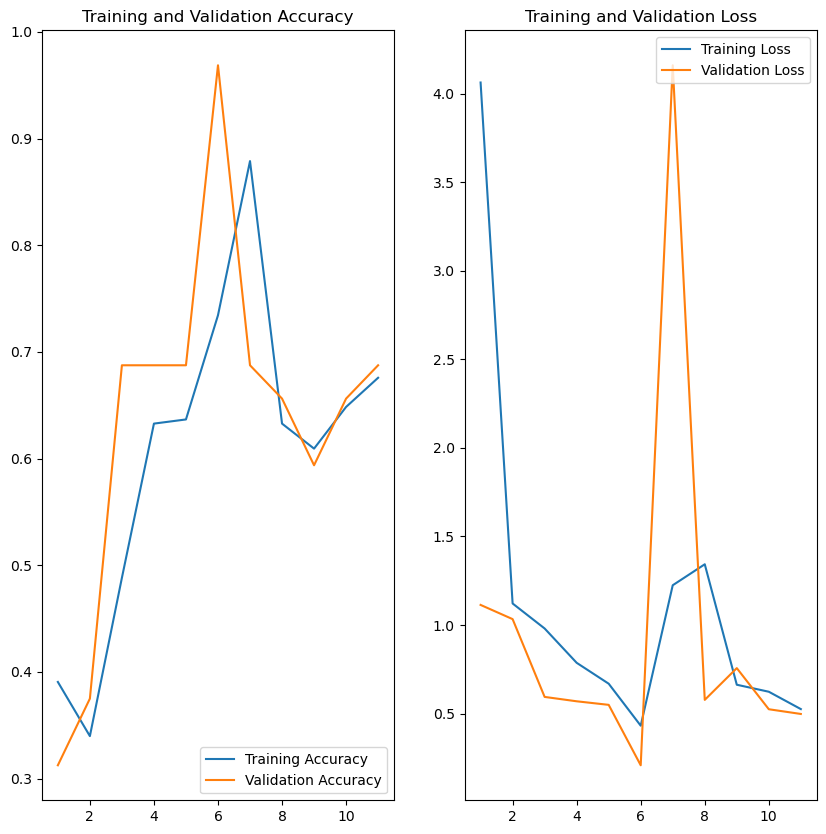

In [10]:
epochs_range = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
model.save('googlenet_paprika.h5')

c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\models\model.py:342: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  warnings.warn(


In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

# Load the trained model
model = load_model(r'C:\Users\Lenovo\Documents\Kuliah - UAJY\Semester V - 2024-2025\Pembelajaran mesin dan Pembelajaran Mendalam - A\Projek UAS\googlenet_paprika.h5')
class_names = ['Hijau', 'Kuning', 'Merah']

def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        input_image = tf.keras.utils.load_img(image_path, target_size=(180, 180))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)

        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        confidence = np.max(result) * 100
        class_idx = np.argmax(result)

        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        input_image = Image.open(image_path)
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

# Example usage
result = classify_images(r'C:\Users\Lenovo\Documents\Kuliah - UAJY\Semester V - 2024-2025\Pembelajaran mesin dan Pembelajaran Mendalam - A\Projek UAS\data_test\Kuning\Prediksi_7.jpeg', save_path='kuning.jpg')
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediksi: Kuning
Confidence: 55.18%
Prediksi: Kuning dengan confidence 55.18%. Gambar asli disimpan di kuning.jpg.


Found 30 files belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


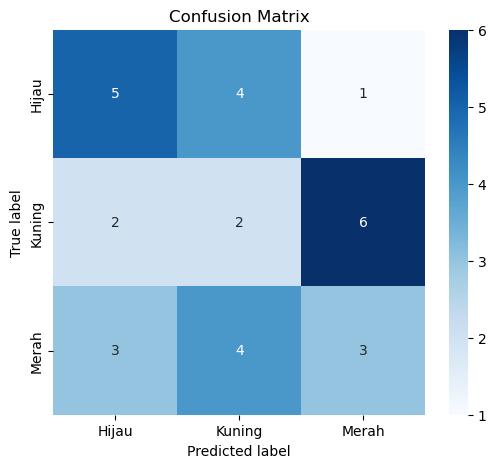

Confusion Matrix
 [[5 4 1]
 [2 2 6]
 [3 4 3]]
Akurasi:
 0.3333333333333333
Prediksi
 [0.5 0.2 0.3]
F1 Score
 [0.5 0.2 0.3]


In [13]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

# Load test data
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\Users\Lenovo\Documents\Kuliah - UAJY\Semester V - 2024-2025\Pembelajaran mesin dan Pembelajaran Mendalam - A\Projek UAS\data_test',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(180, 180)
)

# Predict model
y_pred = model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)

# Extract true labels
true_labels = []
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())
true_labels = tf.convert_to_tensor(true_labels)

# Compute confusion matrix
conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

# Compute accuracy
accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

# Compute precision and recall
precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)

# Compute F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Hijau", "Kuning", "Merah"], 
            yticklabels=["Hijau", "Kuning", "Merah"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Display results
print("Confusion Matrix\n", conf_mat.numpy())
print("Akurasi:\n", accuracy.numpy())
print("Prediksi\n", precision.numpy())
print("F1 Score\n", f1_score.numpy())

In [13]:
print("Josua Waraney William Lantang / 220712071 / Seaborn/ Perbedaan Paprika Merah, Kuning Hijau Menggunakan GoogleNet")

Josua Waraney William Lantang / 220712071 / Seaborn/ Perbedaan Paprika Merah, Kuning Hijau Menggunakan GoogleNet
